# EDA: Анализ данных по онлайн-ритейлу (2010–2011)

**Автор:** Катя Фирсова  
**Дата:** 2025  
**Цель:** выявить особенности покупательского поведения и подготовить данные для моделирования.


## 1. Загрузка данных и импорты

In [41]:
import os
import pandas as pd
from dotenv import load_dotenv
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import numpy as np

In [56]:


load_dotenv()
os.getcwd()

BASE_PATH = Path(os.getenv("HOST_CODE_PATH"))
DATA_RAW_PARQUET = BASE_PATH / "data" / "raw" / "online_retail.parquet"
df = pd.read_parquet(DATA_RAW_PARQUET)

# Смотрим первые строки
df.head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,2010-12-01 08:26:00,7.65,17850.0,United Kingdom
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,2010-12-01 08:26:00,4.25,17850.0,United Kingdom
7,536366,22633,HAND WARMER UNION JACK,6,2010-12-01 08:28:00,1.85,17850.0,United Kingdom
8,536366,22632,HAND WARMER RED POLKA DOT,6,2010-12-01 08:28:00,1.85,17850.0,United Kingdom
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,2010-12-01 08:34:00,1.69,13047.0,United Kingdom


Первые строки показывают структуру данных:
- InvoiceNo — ID заказа.
- StockCode — артикул товара.
- Description - описание товара.
- Quantity - количество проданного товара.
- InvoiceDate - дата продажи.
- UnitPrice - цена за штуку.
- CustomerID - ID клиента.
- Country - страна продажи.

In [57]:
# Размер датасета
df.shape

(541909, 8)

In [58]:
# Проверяем пропуски по колонкам
df.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [59]:
# Информация о типах данных и размере датасета
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  541909 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   541909 non-null  object        
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 33.1+ MB


**Что проверяли:** общую структуру и типы данных.  
**Что увидели:**
- 541 909 строк, 8 колонок.
- Все даты в формате `object` — требуется преобразование в `datetime`.
- `Quantity` — целочисленный признак.
- `UnitPrice` — числовой с плавающей точкой (float).

**Вывод:** типы данных в целом соответствуют ожиданиям, но даты нужно привести к формату `datetime` для корректных временных операций.


In [60]:
# Статистическое описание числовых признаков
df.describe()

,Quantity,InvoiceDate,UnitPrice
count,541909.000000,541909,541909.000000
mean,9.552250,2011-07-04 13:34:57.156386048,4.611114
min,-80995.000000,2010-12-01 08:26:00,-11062.060000
25%,1.000000,2011-03-28 11:34:00,1.250000
50%,3.000000,2011-07-19 17:17:00,2.080000
75%,10.000000,2011-10-19 11:27:00,4.130000
max,80995.000000,2011-12-09 12:50:00,38970.000000
std,218.081158,NaN,96.759853


**Обзор статистики по ключевым признакам:**

- **Quantity (количество):**  
  - Среднее: 9.55  
  - Минимум: -80 995 (очень большое отрицательное значение — возможно, возвраты или ошибки).  
  - Максимум: 80 995 (аномально большое количество, надо проверить выбросы).  
  - Медиана (50%): 3  
  - Стандартное отклонение: 218.08 (высокое — данные очень разбросаны).  

- **InvoiceDate (дата заказа):**  
  - Данные в диапазоне с 01.12.2010 по 09.12.2011.  

- **UnitPrice (цена за единицу):**  
  - Средняя цена: 4.61  
  - Минимум: -11 062 (недопустимое отрицательное значение).  
  - Максимум: 38 970 (возможно, выбросы).  
  - Медиана: 2.08  
  - Стандартное отклонение: 96.76 (значительный разброс).

---

**Выводы:**  
- В колонках `Quantity` и `UnitPrice` есть отрицательные значения, которые, скорее всего, являются ошибками или отражают возвраты.
- Временной диапазон достаточно большой — почти год, можно исследовать сезонные тренды.  
- Ценовые данные сильно разрежены, возможно, есть аномалии, которые влияют на среднее и стандартное отклонение.



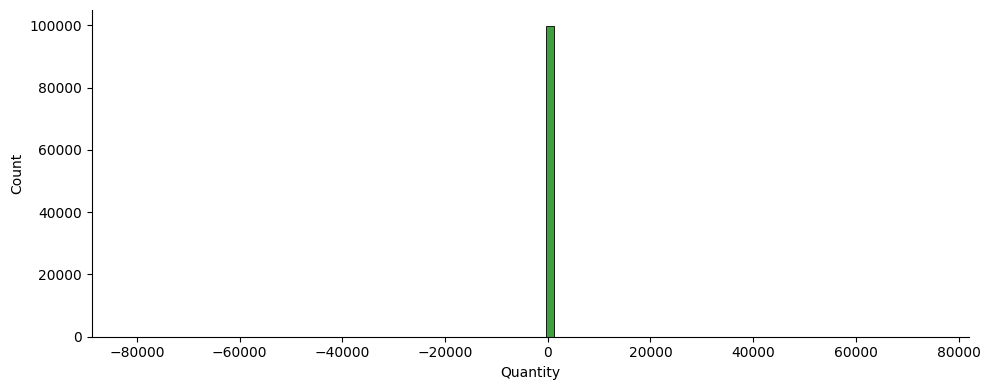

In [47]:
# Аномалии в количестве
df_sample = df.sample(n=100000, random_state=42)
sns.displot(df_sample['Quantity'], bins=100, color='green', height=4, aspect=10/4)

plt.show()

**Что проверяли:** распределение по количеству
**Что увидели:**
- Выбросы явно заметны
- Большинство товаров куплены в малом количестве 

**Вывод:**  
Данные требуют очистки — необходимо обработать выбросы


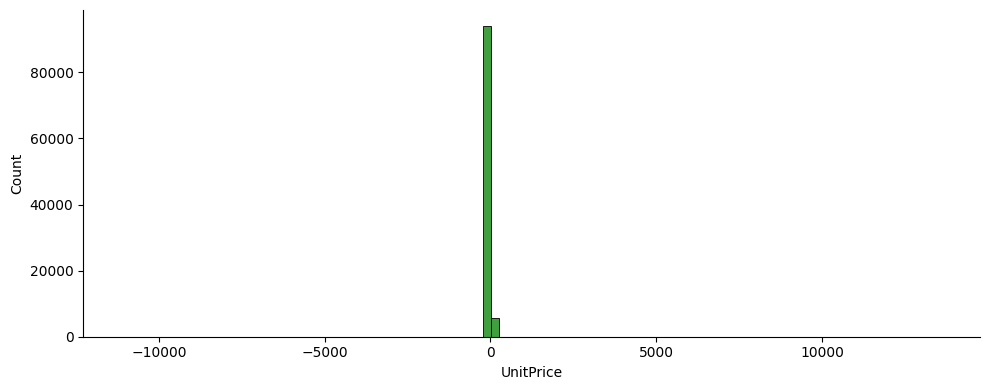

In [48]:
df_sample = df.sample(n=100000, random_state=42)
sns.displot(df_sample['UnitPrice'], bins=100, color='green', height=4, aspect=10/4)

**Что проверяли:** распределение по цене за штуку
- Выбросы явно заметны
- Большинство товаров имеют низкую цену

**Вывод:**  
Данные требуют очистки — необходимо обработать выбросы


In [63]:
df_clean = df[df['UnitPrice'] > 0].copy()
# Проверяем количество полных дубликатов в датасете
num_duplicates = df_clean.duplicated().sum()
percent_duplicates = (num_duplicates / len(df_clean)) * 100
print(f"Количество полных дубликатов: {num_duplicates}, в процентах от всех данных: {percent_duplicates:.2f}%")

# Удаляем дубликаты
df_clean = df_clean.drop_duplicates(subset=df_clean.columns.difference(['InvoiceNo']))



Количество полных дубликатов: 5263, в процентах от всех данных: 0.98%


**Действия:** удалили все полные дубликаты строк сразу, оставив по одному экземпляру каждой.

In [64]:
# Логарифмирование для нормального распределения

df_clean['log_Quantity'] = np.log1p(df_clean['Quantity'].clip(lower=0))
df_clean['log_UnitPrice'] = np.log1p(df_clean['UnitPrice'].clip(lower=1e-6))


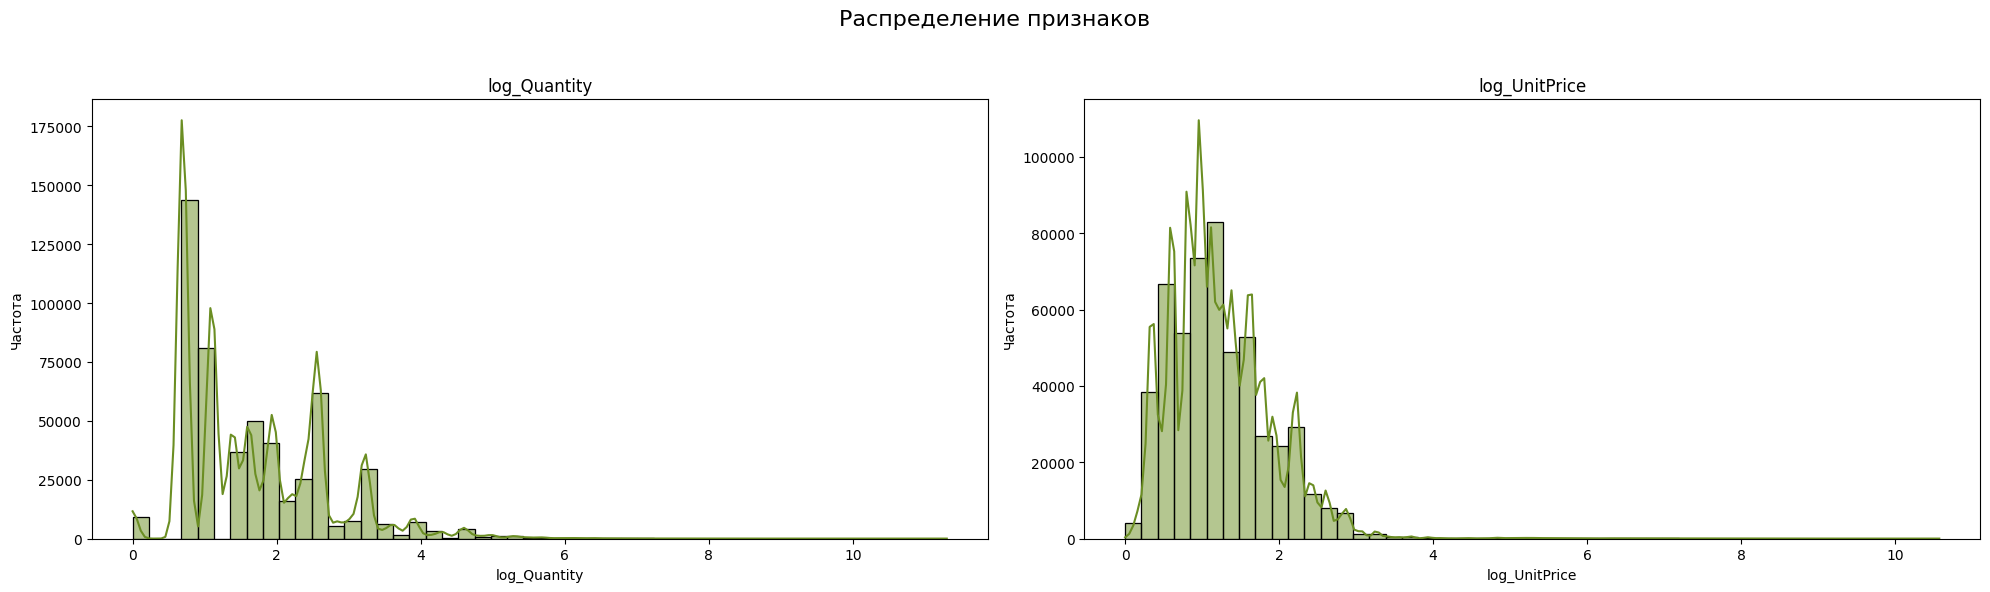

,log_Quantity,log_UnitPrice
count,533551.000000,533551.000000
mean,1.688478,1.246506
std,1.006394,0.655541
min,0.000000,0.001000
25%,0.693147,0.810930
50%,1.386294,1.131402
75%,2.397895,1.635106
max,11.302155,10.570573


In [65]:
plt.figure(figsize=(20, 6))
features = ['log_Quantity', 'log_UnitPrice']


for i, col in enumerate(features):
    plt.subplot(1, 2, i+1)
    sns.histplot(df_clean[col], kde=True, color='olivedrab', bins=50)  
    plt.title(col, fontsize=12)
    plt.tick_params(which='major', labelsize=10)
    plt.xlabel(col, fontsize=10)  
    plt.ylabel('Частота', fontsize=10)

plt.suptitle('Распределение признаков', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

df_clean[['log_Quantity', 'log_UnitPrice']].describe()

**Преобразование признаков Quantity и UnitPrice с помощью логарифмирования**

- Для обработки отрицательных и нулевых значений в признаках были применены ограничения:
  - Все отрицательные значения в `Quantity` обрезаны до нуля (`clip(lower=0)`).
  - Для `UnitPrice` минимальные значения заменены на небольшое положительное число (`1e-6`), чтобы избежать ошибок при логарифмировании.

- Данные готовы для дальнейшего анализа и построения моделей с учётом преобразованных признаков.


## 2. Анализ товаров

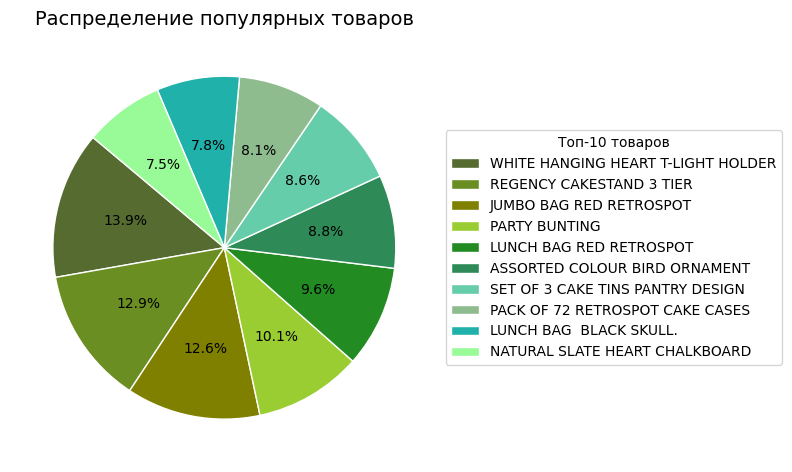

Description
WHITE HANGING HEART T-LIGHT HOLDER    2351
REGENCY CAKESTAND 3 TIER              2187
JUMBO BAG RED RETROSPOT               2140
PARTY BUNTING                         1718
LUNCH BAG RED RETROSPOT               1623
ASSORTED COLOUR BIRD ORNAMENT         1488
SET OF 3 CAKE TINS PANTRY DESIGN      1464
PACK OF 72 RETROSPOT CAKE CASES       1367
LUNCH BAG  BLACK SKULL.               1322
NATURAL SLATE HEART CHALKBOARD        1269
Name: count, dtype: int64

In [66]:
# Популярные товары — топ 10
target_goods = df_clean["Description"].value_counts(ascending=False)[:10]

plt.figure(figsize=(8, 8))

colors = [
    "#556B2F", "#6B8E23", "#808000", "#9ACD32", "#228B22",
    "#2E8B57", "#66CDAA", "#8FBC8F", "#20B2AA", "#98FB98"
]

patches, texts, autotexts = plt.pie(
    target_goods,
    labels=None,
    colors=colors,
    autopct='%1.1f%%',
    startangle=140,
    textprops={'fontsize': 10},
    wedgeprops={'linewidth': 1, 'edgecolor': 'white'}
)

plt.legend(
    patches,
    target_goods.index,
    title="Топ-10 товаров",
    loc="center left",
    bbox_to_anchor=(1, 0.5),
    fontsize=10
)

plt.title("Распределение популярных товаров", fontsize=14)
plt.tight_layout()
plt.show()

target_goods

**Удаление некорректных записей с отсутствующим описанием товара**


In [68]:
# Преобразуем колонку с датой в datetime-формат
df_clean = df_clean.copy()
df_clean["InvoiceDate"] = pd.to_datetime(df_clean["InvoiceDate"])

# Создаём временные признаки для анализа сезонности и поведения клиентов
df_clean["Year"] = df_clean["InvoiceDate"].dt.year           # Год
df_clean["Month"] = df_clean["InvoiceDate"].dt.month         # Месяц
df_clean["Weekday"] = df_clean["InvoiceDate"].dt.weekday + 1 # День недели 
df_clean["WeekdayName"] = df_clean["InvoiceDate"].dt.day_name()  # Название дня недели
df_clean["IsWeekend"] = ((df_clean["Weekday"] + 1).isin([6, 7])).astype(int)  # Выходной (суббота/воскресенье)

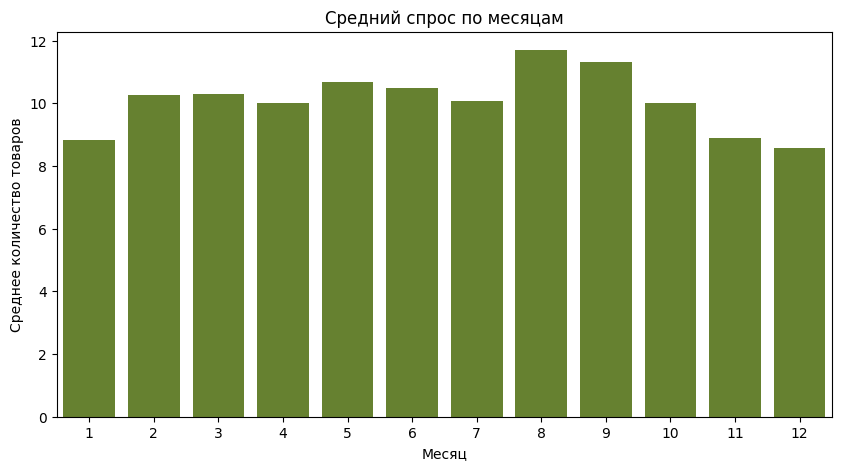

,Month,Quantity
count,12.000000,12.000000
mean,6.500000,10.093083
std,3.605551,0.953271
min,1.000000,8.561570
25%,3.750000,9.733427
50%,6.500000,10.164335
75%,9.250000,10.535478
max,12.000000,11.699493


In [69]:
# Спрос по месяцам
monthly = (
    df_clean
    .groupby('Month')['Quantity']
    .mean()
    .reset_index()
)

plt.figure(figsize=(10, 5))
sns.barplot(data=monthly, x='Month', y='Quantity', color='olivedrab')
plt.title('Средний спрос по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Среднее количество товаров')
plt.show()

monthly.describe()

**Анализ среднего количества товаров по месяцам**

- Данные охватывают все 12 месяцев года.
- Среднее количество покупок по месяцам колеблется от 8.5 в январе до 11.7 в декабре.
- Максимальное среднее количество приходится на декабрь, что может быть связано с сезонными праздничными распродажами.
- Эти данные помогут планировать запасы и маркетинговые кампании с учётом сезонности.

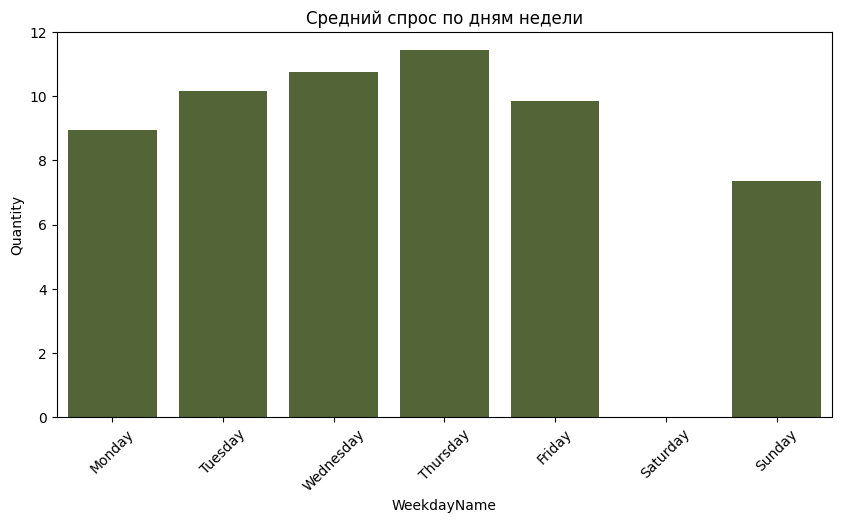

,Quantity
count,6.000000
mean,9.757553
std,1.442125
min,7.360764
25%,9.184553
50%,10.005632
75%,10.620337
max,11.437187


In [70]:
# Спрос по дням недели
weekday = (
    df_clean
    .groupby('WeekdayName')['Quantity']
    .mean()
    .reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
    .reset_index()
)

plt.figure(figsize=(10, 5))
sns.barplot(data=weekday, x='WeekdayName', y='Quantity', color='darkolivegreen')
plt.title('Средний спрос по дням недели')
plt.xticks(rotation=45)
plt.show()

weekday.describe()

**Анализ количества покупок по дням недели**

- Данные представлены за 6 дней недели.
- Среднее количество покупок — около 9.5 единиц, с умеренным разбросом.
- Минимум (7.36) и максимум (11.34) показывают вариативность в разные дни.
- Отсутствие данных по субботе указывает на возможный выходной или отсутствие продаж в этот день.


## 3. Новые нужные признаки 

In [71]:
# Вычисляем общую сумму покупки и логарифм от неё (с защитой от отрицательных и нулевых значений)
df_clean['TotalSum'] = df_clean['Quantity'] * df_clean['UnitPrice']

df_clean['log_TotalSum'] = np.log1p(
    (df_clean['Quantity'].clip(lower=0) * df_clean['UnitPrice'].clip(lower=1e-6)).clip(lower=0)
)

# Временные признаки из даты
df_clean['TransactionHour'] = df_clean['InvoiceDate'].dt.hour
df_clean['DayOfYear'] = df_clean['InvoiceDate'].dt.dayofyear

# Признаки начала и конца месяца
df_clean['IsStartOfMonth'] = df_clean['InvoiceDate'].dt.is_month_start.astype(int)
df_clean['IsEndOfMonth'] = df_clean['InvoiceDate'].dt.is_month_end.astype(int)

# Признак скидки: цена товара ниже медианной цены по этому товару
unitprice_median = df_clean.groupby('StockCode')['UnitPrice'].transform('median')
df_clean['IsDiscounted'] = (df_clean['UnitPrice'] < unitprice_median).astype(int)

# Праздничный сезон — ноябрь и декабрь
df_clean['HolidaySeason'] = df_clean['InvoiceDate'].dt.month.isin([11, 12]).astype(int)

# Черная пятница — последний пятничный уикенд ноября (условно с 23 по 29 ноября и пятница)
df_clean['BlackFriday'] = (
    (df_clean['InvoiceDate'].dt.month == 11) &
    (df_clean['InvoiceDate'].dt.day.between(23, 29)) &
    (df_clean['InvoiceDate'].dt.weekday == 4)
).astype(int)

# Сезонные признаки через синусы и косинусы для учета цикличности месяца и дня недели
df_clean['Month_sin'] = np.sin(2 * np.pi * df_clean['InvoiceDate'].dt.month / 12)
df_clean['Month_cos'] = np.cos(2 * np.pi * df_clean['InvoiceDate'].dt.month / 12)
df_clean['Weekday_sin'] = np.sin(2 * np.pi * df_clean['InvoiceDate'].dt.weekday / 7)
df_clean['Weekday_cos'] = np.cos(2 * np.pi * df_clean['InvoiceDate'].dt.weekday / 7)

# Бинарный признак самых популярных товаров (топ-10 по количеству продаж)
top_10_items = df_clean['StockCode'].value_counts().head(10).index
df_clean['IsPopularItem'] = df_clean['StockCode'].isin(top_10_items).astype(int)
df_clean.describe().T

,count,mean,min,25%,50%,75%,max,std
Quantity,533551.0,9.925351,-80995.0,1.0,3.0,10.0,80995.0,216.568951
InvoiceDate,533551,2011-07-04 14:05:33.114472960,2010-12-01 08:26:00,2011-03-28 11:59:00,2011-07-20 10:51:00,2011-10-19 09:59:00,2011-12-09 12:50:00,NaN
UnitPrice,533551.0,4.694266,0.001,1.25,2.1,4.13,38970.0,95.130539
log_Quantity,533551.0,1.688478,0.0,0.693147,1.386294,2.397895,11.302155,1.006394
log_UnitPrice,533551.0,1.246506,0.001,0.81093,1.131402,1.635106,10.570573,0.655541
Year,533551.0,2010.922011,2010.0,2011.0,2011.0,2011.0,2011.0,0.268154
Month,533551.0,7.549055,1.0,5.0,8.0,11.0,12.0,3.508418
Weekday,533551.0,3.426132,1.0,2.0,3.0,5.0,7.0,1.842064
IsWeekend,533551.0,0.151672,0.0,0.0,0.0,0.0,1.0,0.358703
TotalSum,533551.0,18.259758,-168469.6,3.75,9.9,17.7,168469.6,381.149423


## 4. Сегментация клиентов (RFM + Кластеризация)

In [73]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from datetime import timedelta

In [74]:
def add_rfm_clusters(df, n_clusters=3, plot_elbow=True):
    
    # Фильтрация возвратов
    df_filt = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)].copy()

    # Удаление выбросов по Quantity и UnitPrice (между 1 и 99 перцентилями)
    q_low_qty = df_filt['Quantity'].quantile(0.01)
    q_high_qty = df_filt['Quantity'].quantile(0.99)
    q_low_price = df_filt['UnitPrice'].quantile(0.01)
    q_high_price = df_filt['UnitPrice'].quantile(0.99)

    df_filt = df_filt[
        (df_filt['Quantity'] >= q_low_qty) & (df_filt['Quantity'] <= q_high_qty) &
        (df_filt['UnitPrice'] >= q_low_price) & (df_filt['UnitPrice'] <= q_high_price)
    ].copy()

    # Расчёт TotalSum
    df_filt['TotalSum'] = df_filt['Quantity'] * df_filt['UnitPrice']

    # Определение max_date
    max_date = df_filt['InvoiceDate'].max() + timedelta(days=1)

    # RFM-расчёт
    rfm_df = df_filt.groupby('CustomerID').agg(
        Recency=('InvoiceDate', lambda x: (max_date - x.max()).days),
        Frequency=('InvoiceNo', 'nunique'),
        Monetary=('TotalSum', 'sum')
    ).reset_index()

    # Стандартизация
    scaler_rfm = StandardScaler()
    rfm_scaled = scaler_rfm.fit_transform(rfm_df[['Recency', 'Frequency', 'Monetary']])

    # Метод локтя
    if plot_elbow:
        wcss_list = []
        max_k = 10
        for k in range(1, max_k + 1):
            kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
            kmeans.fit(rfm_scaled)
            wcss_list.append(kmeans.inertia_)

        plt.figure(figsize=(6, 3))
        plt.plot(range(1, max_k + 1), wcss_list, marker='o', color="green")
        plt.xlabel('Количество кластеров k')
        plt.ylabel('WCSS (Inertia)')
        plt.title('Метод локтя для выбора числа кластеров (RFM)')
        plt.grid(True)
        plt.show()

    # Кластеризация
    kmeans_model = KMeans(n_clusters=n_clusters, random_state=42)
    rfm_df['RFM_Cluster'] = kmeans_model.fit_predict(rfm_scaled)

    # Вывод статистики по кластерам
    cluster_stats = rfm_df.groupby('RFM_Cluster').agg(
        Customers=('CustomerID', 'count'),
        Recency_Mean=('Recency', 'mean'),
        Frequency_Mean=('Frequency', 'mean'),
        Monetary_Mean=('Monetary', 'mean')
    ).reset_index()

    for idx, row in cluster_stats.iterrows():
        print(f"Кластер {int(row['RFM_Cluster'])}:")
        print(f"  - Клиентов: {row['Customers']:,}")
        print(f"  - Среднее Recency : {row['Recency_Mean']:.2f}")
        print(f"  - Среднее Frequency : {row['Frequency_Mean']:.2f}")
        print(f"  - Среднее Monetary : {row['Monetary_Mean']:.2f}")
        print()

    # Объединение меток кластеров с исходным датафреймом
    df_with_clusters = df.merge(
        rfm_df[['CustomerID', 'RFM_Cluster']],
        on='CustomerID',
        how='left'
    )

    return df_with_clusters, rfm_df


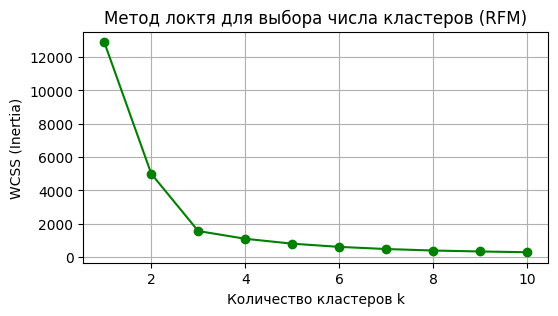

Кластер 0:
  - Клиентов: 3,223.0
  - Среднее Recency : 41.26
  - Среднее Frequency : 5.04
  - Среднее Monetary : 1960.44

Кластер 1:
  - Клиентов: 1.0
  - Среднее Recency : 1.00
  - Среднее Frequency : 1390.00
  - Среднее Monetary : 1287658.51

Кластер 2:
  - Клиентов: 1,070.0
  - Среднее Recency : 247.71
  - Среднее Frequency : 1.61
  - Среднее Monetary : 450.07

RFM_Cluster
0.0    368998
1.0    132027
2.0     32275
Name: count, dtype: int64


In [75]:
# Допустим, у тебя DataFrame называется df_full
df_with_clusters, rfm_df = add_rfm_clusters(df_clean, n_clusters=3, plot_elbow=True)
print(df_with_clusters['RFM_Cluster'].value_counts())



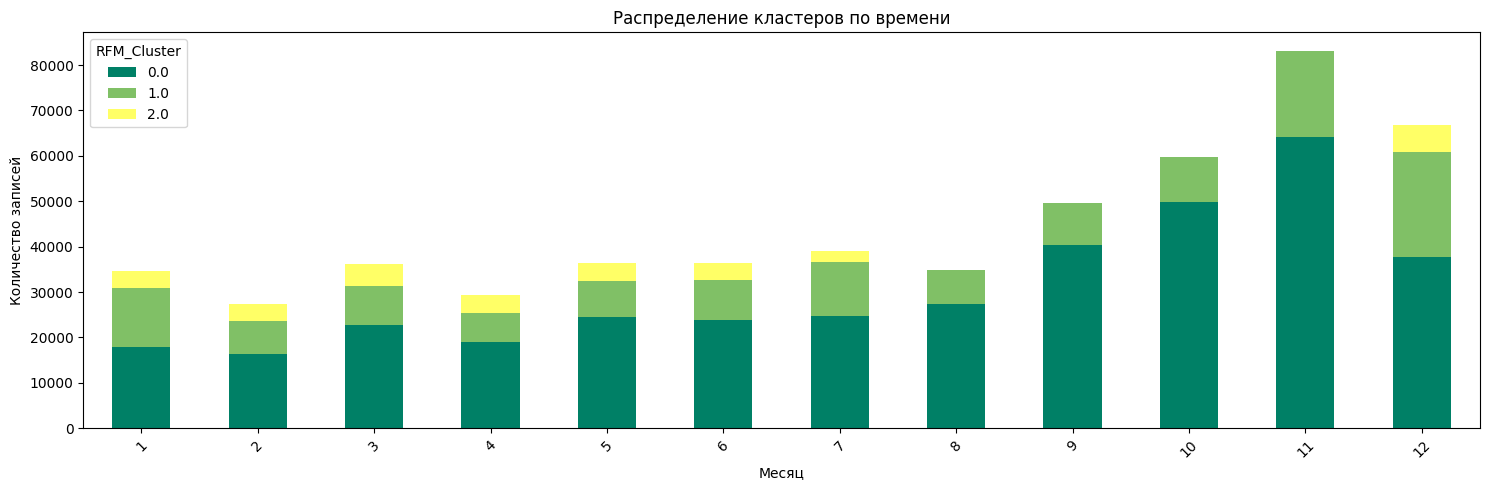

In [76]:
cluster_counts = df_with_clusters.groupby(['Month', 'RFM_Cluster']).size().unstack(fill_value=0)
cluster_counts.plot(kind='bar', stacked=True, figsize=(15, 5), colormap='summer')
plt.title("Распределение кластеров по времени")
plt.ylabel("Количество записей")
plt.xlabel("Месяц")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

1. **Подготовка данных**  
   - Удалены дубликаты, пропуски в `CustomerID`, возвраты (`Quantity <= 0`) и некорректные значения `UnitPrice`, рассчитан новый признак `TotalSum = Quantity * UnitPrice`.

2. **Построение RFM-таблицы**  
   - Для каждого клиента вычислены метрики:
     - **Recency** — количество дней с последней покупки.
     - **Frequency** — число уникальных покупок.
     - **Monetary** — сумма всех покупок.

3. **Стандартизация признаков**  
   - Применён `StandardScaler` для нормализации признаков перед кластеризацией.

4. **Определение числа кластеров (метод локтя)**  

5. **Кластеризация и анализ**  
   - Выполнено разбиение на 3 кластера.
   - Рассчитана базовая статистика по кластерам.

---

- Кластер 0 — основные активные покупатели с регулярной покупательской активностью.
- Кластер 1 — VIP-клиент с экстремально высокой активностью и суммой покупок.
- Кластер 2 — клиенты с низкой активностью и небольшими суммами покупок, которые давно не совершали покупок.


# 5. Создание Lags и Rollings

In [77]:
def add_lag_rolling_features(df, qty_col='Quantity', date_col='InvoiceDate', code_col='StockCode', price_col='UnitPrice'):
    # Копируем входной df
    df_work = df.copy()

    # Фильтрация по разумным значениям количества и цены
    df_work = df_work[
        (df_work[qty_col].between(1, 999)) & 
        (df_work[price_col].between(0.01, 9999))
    ].copy()

    # Аггрегация: сумма quantity по дате и товару
    agg = (df_work
           .groupby([date_col, code_col], as_index=False)[qty_col]
           .sum()
           .rename(columns={qty_col: 'Quantity_Agg'})
           .sort_values([code_col, date_col])
           .reset_index(drop=True))

    # Квантили для обрезки лагов
    q_low_lag, q_high_lag = agg['Quantity_Agg'].quantile([0.01, 0.99])

    # Создаем лаги с обрезкой по квантилям
    lag_cols = []
    for lag in [1, 7, 14, 30, 60]:
        lag_col = f'Lag_{lag}'
        lag_vals = agg.groupby(code_col)['Quantity_Agg'].shift(lag)
        agg[lag_col] = lag_vals.clip(lower=q_low_lag, upper=q_high_lag).fillna(0).reset_index(level=0, drop=True)

        lag_cols.append(lag_col)

    # Скользящие показатели
    rolling_norm_cols = []
    rolling_range_cols = []
    rolling_pct_cols = []

    for window in [7, 14, 30, 60]:
        group = agg.groupby(code_col)['Quantity_Agg']

        rolling_mean = group.rolling(window=window, min_periods=1).mean()
        rolling_std = group.rolling(window=window, min_periods=1).std().fillna(1)
        rolling_std_safe = rolling_std.replace(0, 1e-9)
        rolling_norm_mean = rolling_mean / rolling_std_safe


        # Квантили для обрезки
        q_low_rnm, q_high_rnm = pd.Series(rolling_norm_mean.values).quantile([0.01, 0.99])
        col_norm = f'RollingNormMean_{window}'
        agg[col_norm] = rolling_norm_mean.clip(lower=q_low_rnm, upper=q_high_rnm).reset_index(level=0, drop=True)
        rolling_norm_cols.append(col_norm)

        rolling_range = group.rolling(window=window, min_periods=1).max() - group.rolling(window=window, min_periods=1).min()
        q_low_rr, q_high_rr = rolling_range.quantile([0.01, 0.99])
        col_range = f'RollingRange_{window}'
        agg[col_range] = rolling_range.clip(lower=q_low_rr, upper=q_high_rr).fillna(0).reset_index(level=0, drop=True)
        rolling_range_cols.append(col_range)

        pct_change = group.pct_change(periods=window).fillna(0)
        col_pct = f'RollingPctChange_{window}'
        agg[col_pct] = pct_change.clip(-1, 1).reset_index(level=0, drop=True)
        rolling_pct_cols.append(col_pct)

    # Относительные изменения между лагами
    pct_change_cols = []
    for name, (num_col, denom_col) in {
        'PctChange_7': ('Lag_1', 'Lag_7'),
        'PctChange_14': ('Lag_1', 'Lag_14'),
        'PctChange_30': ('Lag_1', 'Lag_30'),
        'PctChange_60': ('Lag_1', 'Lag_60')
    }.items():
        if num_col in agg.columns and denom_col in agg.columns:
            denom_vals = agg[denom_col].replace(0, np.nan)
            pct = (agg[num_col] - agg[denom_col]) / denom_vals
            agg[name] = pct.fillna(0).clip(-1, 1).reset_index(level=0, drop=True)
            pct_change_cols.append(name)

    # Колонки для слияния
    merge_cols = [c for c in agg.columns if c != 'Quantity_Agg']

    # Объединение с исходным df по дате и коду товара
    df_merged = pd.merge(
        df,
        agg[merge_cols].reset_index(drop=True),
        on=[date_col, code_col],
        how='left'
    )

    dict_cols = {
        'Лаги': lag_cols,
        'Нормированные скользящие средние': rolling_norm_cols,
        'Диапазон скользящих значений': rolling_range_cols,
        'Процентные изменения': rolling_pct_cols,
        'Относительные изменения': pct_change_cols
    }

    return df_merged, dict_cols


In [78]:
df_with_lags, dict_cols = add_lag_rolling_features(
    df_with_clusters,
    qty_col='Quantity',
    date_col='InvoiceDate',
    code_col='StockCode',
    price_col='UnitPrice'
)


In [79]:
for group_name, cols in dict_cols.items():
    print(f"\n{group_name}:\n")
    display(df_with_lags[cols].describe().T[['mean','std','min','25%','50%','75%','max']])


Лаги:



,mean,std,min,25%,50%,75%,max
Lag_1,8.889894,15.321354,0.0,1.0,4.0,12.0,100.0
Lag_7,8.626077,15.214506,0.0,1.0,3.0,10.0,100.0
Lag_14,8.316959,15.045371,0.0,1.0,3.0,10.0,100.0
Lag_30,7.680909,14.708568,0.0,1.0,2.0,10.0,100.0
Lag_60,6.639598,14.082016,0.0,0.0,2.0,7.0,100.0



Нормированные скользящие средние:



,mean,std,min,25%,50%,75%,max
RollingNormMean_7,1.817166e+07,1.335720e+08,0.437298,0.830798,1.149932,1.596042,1.000000e+09
RollingNormMean_14,9.963318e+06,9.931802e+07,0.342243,0.701750,0.990683,1.345328,1.000000e+09
RollingNormMean_30,9.752821e-01,7.165204e-01,0.275327,0.591957,0.835701,1.140090,6.000000e+00
RollingNormMean_60,8.753087e-01,6.950401e-01,0.239816,0.532282,0.729832,1.007007,6.000000e+00



Диапазон скользящих значений:



,mean,std,min,25%,50%,75%,max
RollingRange_7,29.859308,48.597181,0.0,6.0,11.0,25.0,299.0
RollingRange_14,47.286309,72.269344,0.0,11.0,23.0,47.0,455.0
RollingRange_30,72.749620,99.151232,0.0,15.0,35.0,95.0,575.0
RollingRange_60,100.108028,122.376316,0.0,23.0,49.0,119.0,639.0



Процентные изменения:



,mean,std,min,25%,50%,75%,max
RollingPctChange_7,0.091814,0.711307,-0.998889,-0.500000,0.0,1.0,1.0
RollingPctChange_14,0.086773,0.697949,-0.998971,-0.500000,0.0,1.0,1.0
RollingPctChange_30,0.075377,0.668668,-0.998843,-0.500000,0.0,1.0,1.0
RollingPctChange_60,0.057948,0.616337,-0.998992,-0.333333,0.0,0.5,1.0



Относительные изменения:



,mean,std,min,25%,50%,75%,max
PctChange_7,0.090523,0.710238,-0.99,-0.500000,0.0,1.0,1.0
PctChange_14,0.085087,0.697163,-0.99,-0.500000,0.0,1.0,1.0
PctChange_30,0.073568,0.668119,-0.99,-0.500000,0.0,1.0,1.0
PctChange_60,0.057396,0.616124,-0.99,-0.359245,0.0,0.5,1.0


- **Лаги** показывают, как среднее количество продаж уменьшается с ростом периода задержки, что ожидаемо — продажи в отдалённом прошлом влияют меньше.
- **Нормированные скользящие средние** имеют огромные выбросы у некоторых товаров (максимумы в миллиардах), стоит дополнительно проверить и, возможно, нормализовать.
- **Диапазоны скользящих значений** растут с увеличением окна — продажи становятся более изменчивыми за длительные периоды.
- **Процентные и относительные изменения** варьируются от -1 до 1, что отражает сильную волатильность спроса.


# 6. Снова статистика

In [80]:
df_with_lags.duplicated().sum()

0

In [81]:
null_counts = df_with_lags.isnull().sum().to_dict()
str(null_counts)

"{'InvoiceNo': 0, 'StockCode': 0, 'Description': 0, 'Quantity': 0, 'InvoiceDate': 0, 'UnitPrice': 0, 'CustomerID': 0, 'Country': 0, 'log_Quantity': 0, 'log_UnitPrice': 0, 'Year': 0, 'Month': 0, 'Weekday': 0, 'WeekdayName': 0, 'IsWeekend': 0, 'TotalSum': 0, 'log_TotalSum': 0, 'TransactionHour': 0, 'DayOfYear': 0, 'IsStartOfMonth': 0, 'IsEndOfMonth': 0, 'IsDiscounted': 0, 'HolidaySeason': 0, 'BlackFriday': 0, 'Month_sin': 0, 'Month_cos': 0, 'Weekday_sin': 0, 'Weekday_cos': 0, 'IsPopularItem': 0, 'RFM_Cluster': 251, 'Lag_1': 9328, 'Lag_7': 9328, 'Lag_14': 9328, 'Lag_30': 9328, 'Lag_60': 9328, 'RollingNormMean_7': 9328, 'RollingRange_7': 9328, 'RollingPctChange_7': 9328, 'RollingNormMean_14': 9328, 'RollingRange_14': 9328, 'RollingPctChange_14': 9328, 'RollingNormMean_30': 9328, 'RollingRange_30': 9328, 'RollingPctChange_30': 9328, 'RollingNormMean_60': 9328, 'RollingRange_60': 9328, 'RollingPctChange_60': 9328, 'PctChange_7': 9328, 'PctChange_14': 9328, 'PctChange_30': 9328, 'PctChange_60

In [82]:
cols_with_na = [
    'Lag_1','Lag_7','Lag_14','Lag_30','Lag_60',
    'RollingNormMean_7','RollingRange_7','RollingPctChange_7',
    'RollingNormMean_14','RollingRange_14','RollingPctChange_14',
    'RollingNormMean_30','RollingRange_30','RollingPctChange_30',
    'RollingNormMean_60','RollingRange_60','RollingPctChange_60',
    'PctChange_7','PctChange_14','PctChange_30','PctChange_60'
]
df_with_lags = df_with_lags.dropna(subset=cols_with_na)

In [106]:
cols_to_drop = ['Quantity', 'TotalSum', 'UnitPrice']
df_with_lags = df_with_lags.drop(columns=[col for col in cols_to_drop if col in df_with_lags.columns])
numeric_cols = [
            col for col in df_clean.select_dtypes(include=np.number).columns
            if col != "log_Quantity"
        ]

In [107]:
corr_matrix = df_with_lags[numeric_cols + ["log_Quantity"]].corr()
target = ["log_Quantity"]

In [108]:
target_corr = corr_matrix["log_Quantity"].abs().sort_values(ascending=False)
top_features = target_corr.drop(target).head(15).index.tolist()

# 7. Модель LSTM, обучение, прогноз

In [116]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import (
    MinMaxScaler,
    StandardScaler,
    OrdinalEncoder
)
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, median_absolute_error,
    r2_score, mean_absolute_percentage_error, max_error
)
from sklearn.model_selection import TimeSeriesSplit
from collections import Counter

In [117]:
target = 'log_Quantity'  
selected_features = top_features
df_with_lags = df_with_lags.sort_values('InvoiceDate').reset_index(drop=True)
selected_features
df_clean = df_with_lags.copy()

In [118]:
def scale_and_write_back(df_train, df_test, features, target):
    scaler_X = StandardScaler()
    scaler_y = StandardScaler()

    df_train_scaled = df_train.copy()
    df_test_scaled = df_test.copy()

    df_train_scaled[features] = scaler_X.fit_transform(df_train[features])
    df_test_scaled[features] = scaler_X.transform(df_test[features])

    df_train_scaled[target] = scaler_y.fit_transform(df_train[[target]])
    df_test_scaled[target] = scaler_y.transform(df_test[[target]])

    return df_train_scaled, df_test_scaled, scaler_X, scaler_y


In [119]:
def create_multivariate_sequences(df, features, target, window_size):
    feature_values = df[features].values
    target_values = df[target].values
    n_samples = len(df) - window_size

    X = np.zeros((n_samples, window_size, len(features)))
    y = np.zeros(n_samples)

    for i in range(n_samples):
        X[i] = feature_values[i:i+window_size]
        y[i] = target_values[i+window_size]

    indices = df.index[window_size:]
    return X, y, indices

In [120]:
def build_lstm_model(window_size, n_features):
    model = Sequential([
        LSTM(64, activation='relu', input_shape=(window_size, n_features), return_sequences=False),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

In [121]:
def predict_and_evaluate(model, X_test_seq, y_test_seq, scaler_y):
    y_pred_scaled = model.predict(X_test_seq)

    # inverse scaling
    y_pred_log = scaler_y.inverse_transform(y_pred_scaled)
    y_true_log = scaler_y.inverse_transform(y_test_seq.reshape(-1, 1))

    # inverse log1p
    y_pred = np.expm1(y_pred_log).flatten()
    y_true = np.expm1(y_true_log).flatten()

    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)

    return rmse, mae, y_true, y_pred

In [122]:
tscv = TimeSeriesSplit(n_splits=3)
fold_metrics = []
window_size = 7

In [123]:
for fold, (train_idx, val_idx) in enumerate(tscv.split(df_clean)):
    print(f"\n--- Fold {fold + 1} ---")

    df_train = df_clean.iloc[train_idx].copy()
    df_val = df_clean.iloc[val_idx].copy()
    
    # Масштабирование
    df_train_scaled, df_val_scaled, scaler_X, scaler_y = scale_and_write_back(
        df_train, df_val, selected_features, target
    )

    # Создание последовательностей из данных
    X_train_seq, y_train_seq, indices_train = create_multivariate_sequences(df_train_scaled, selected_features, target, window_size)
    X_val_seq, y_val_seq, indices_test = create_multivariate_sequences(df_val_scaled, selected_features, target, window_size)

    # Построение и обучение модели
    model = build_lstm_model(window_size, X_train_seq.shape[2])
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    model.fit(
        X_train_seq, y_train_seq,
        epochs=100,
        batch_size=64,
        validation_data=(X_val_seq, y_val_seq),
        callbacks=[early_stopping],
        verbose=2
    )
    # Предсказание и оценка
    rmse, mae, y_true, y_pred = predict_and_evaluate(model, X_val_seq, y_val_seq, scaler_y)
    fold_metrics.append({'fold': fold + 1, 'RMSE': rmse, 'MAE': mae})
    print(f"Fold {fold + 1} — RMSE: {rmse:.2f}, MAE: {mae:.2f}")

    


--- Fold 1 ---


C:\Users\Ekaterina\anaconda3\envs\demand_forecast\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
2048/2048 - 26s - 12ms/step - loss: 0.5593 - mae: 0.5638 - val_loss: 0.5870 - val_mae: 0.5587
Epoch 2/100
2048/2048 - 22s - 11ms/step - loss: 0.5410 - mae: 0.5509 - val_loss: 0.5924 - val_mae: 0.5951
Epoch 3/100
2048/2048 - 22s - 11ms/step - loss: 0.5381 - mae: 0.5490 - val_loss: 0.5780 - val_mae: 0.5711
Epoch 4/100
2048/2048 - 20s - 10ms/step - loss: 0.5360 - mae: 0.5478 - val_loss: 0.5803 - val_mae: 0.5747
Epoch 5/100
2048/2048 - 18s - 9ms/step - loss: 0.5346 - mae: 0.5471 - val_loss: 0.5821 - val_mae: 0.5720
Epoch 6/100
2048/2048 - 18s - 9ms/step - loss: 0.5328 - mae: 0.5460 - val_loss: 0.5819 - val_mae: 0.5803
Epoch 7/100
2048/2048 - 18s - 9ms/step - loss: 0.5315 - mae: 0.5451 - val_loss: 0.5768 - val_mae: 0.5691
Epoch 8/100
2048/2048 - 18s - 9ms/step - loss: 0.5309 - mae: 0.5446 - val_loss: 0.5793 - val_mae: 0.5796
Epoch 9/100
2048/2048 - 18s - 9ms/step - loss: 0.5306 - mae: 0.5445 - val_loss: 0.5903 - val_mae: 0.5865
Epoch 10/100
2048/2048 - 18s - 9ms/step - loss: 0.5

C:\Users\Ekaterina\anaconda3\envs\demand_forecast\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
4096/4096 - 42s - 10ms/step - loss: 0.5536 - mae: 0.5581 - val_loss: 0.5444 - val_mae: 0.5594
Epoch 2/100
4096/4096 - 34s - 8ms/step - loss: 0.5396 - mae: 0.5491 - val_loss: 0.5413 - val_mae: 0.5473
Epoch 3/100
4096/4096 - 33s - 8ms/step - loss: 0.5373 - mae: 0.5477 - val_loss: 0.5450 - val_mae: 0.5635
Epoch 4/100
4096/4096 - 34s - 8ms/step - loss: 0.5351 - mae: 0.5459 - val_loss: 0.5439 - val_mae: 0.5533
Epoch 5/100
4096/4096 - 33s - 8ms/step - loss: 0.5329 - mae: 0.5447 - val_loss: 0.5484 - val_mae: 0.5639
Epoch 6/100
4096/4096 - 34s - 8ms/step - loss: 0.5323 - mae: 0.5442 - val_loss: 0.5445 - val_mae: 0.5557
Epoch 7/100
4096/4096 - 29s - 7ms/step - loss: 0.5312 - mae: 0.5439 - val_loss: 0.5467 - val_mae: 0.5644
4096/4096 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step
Fold 2 — RMSE: 26.31, MAE: 7.24

--- Fold 3 ---


C:\Users\Ekaterina\anaconda3\envs\demand_forecast\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
6144/6144 - 51s - 8ms/step - loss: 0.5398 - mae: 0.5509 - val_loss: 0.5202 - val_mae: 0.5400
Epoch 2/100
6144/6144 - 46s - 8ms/step - loss: 0.5290 - mae: 0.5436 - val_loss: 0.5186 - val_mae: 0.5361
Epoch 3/100
6144/6144 - 47s - 8ms/step - loss: 0.5258 - mae: 0.5416 - val_loss: 0.5257 - val_mae: 0.5408
Epoch 4/100
6144/6144 - 46s - 7ms/step - loss: 0.5240 - mae: 0.5404 - val_loss: 0.5228 - val_mae: 0.5395
Epoch 5/100
6144/6144 - 46s - 7ms/step - loss: 0.5228 - mae: 0.5395 - val_loss: 0.5165 - val_mae: 0.5398
Epoch 6/100
6144/6144 - 46s - 7ms/step - loss: 0.5218 - mae: 0.5391 - val_loss: 0.5255 - val_mae: 0.5408
Epoch 7/100
6144/6144 - 45s - 7ms/step - loss: 0.5205 - mae: 0.5383 - val_loss: 0.5195 - val_mae: 0.5489
Epoch 8/100
6144/6144 - 48s - 8ms/step - loss: 0.5200 - mae: 0.5380 - val_loss: 0.5238 - val_mae: 0.5481
Epoch 9/100
6144/6144 - 46s - 8ms/step - loss: 0.5190 - mae: 0.5374 - val_loss: 0.5211 - val_mae: 0.5420
Epoch 10/100
6144/6144 - 47s - 8ms/step - loss: 0.5182 

In [124]:
# 1. Масштабирование
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_scaled = scaler_X.fit_transform(df_clean[features].values)
y_scaled = scaler_y.fit_transform(df_clean[[target]].values)

# 2. Создаём последовательности
def make_sequences(X, y, window_size):
    X_seq, y_seq, indices = [], [], []
    for i in range(window_size, len(X)):
        X_seq.append(X[i - window_size:i])
        y_seq.append(y[i])
        indices.append(df_clean.index[i])
    return np.array(X_seq), np.array(y_seq), indices

X, y, indices = make_sequences(X_scaled, y_scaled, window_size)

# 3. Модель
model = Sequential([
    LSTM(64, activation='tanh', input_shape=(window_size, len(features))),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# 4. Обучение
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(X, y, validation_split=0.1, epochs=50, batch_size=64, callbacks=[early_stop], verbose=1)

Epoch 1/50


C:\Users\Ekaterina\anaconda3\envs\demand_forecast\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7372/7372 ━━━━━━━━━━━━━━━━━━━━ 58s 8ms/step - loss: 0.5407 - mae: 0.5504 - val_loss: 0.5184 - val_mae: 0.5411
Epoch 2/50
7372/7372 ━━━━━━━━━━━━━━━━━━━━ 55s 7ms/step - loss: 0.5363 - mae: 0.5471 - val_loss: 0.5133 - val_mae: 0.5365
Epoch 3/50
7372/7372 ━━━━━━━━━━━━━━━━━━━━ 49s 7ms/step - loss: 0.5346 - mae: 0.5459 - val_loss: 0.5139 - val_mae: 0.5342
Epoch 4/50
7372/7372 ━━━━━━━━━━━━━━━━━━━━ 50s 7ms/step - loss: 0.5334 - mae: 0.5453 - val_loss: 0.5120 - val_mae: 0.5325
Epoch 5/50
7372/7372 ━━━━━━━━━━━━━━━━━━━━ 49s 7ms/step - loss: 0.5325 - mae: 0.5448 - val_loss: 0.5147 - val_mae: 0.5269
Epoch 6/50
7372/7372 ━━━━━━━━━━━━━━━━━━━━ 53s 7ms/step - loss: 0.5317 - mae: 0.5441 - val_loss: 0.5127 - val_mae: 0.5387
Epoch 7/50
7372/7372 ━━━━━━━━━━━━━━━━━━━━ 52s 7ms/step - loss: 0.5313 - mae: 0.5440 - val_loss: 0.5122 - val_mae: 0.5416
Epoch 8/50
7372/7372 ━━━━━━━━━━━━━━━━━━━━ 57s 8ms/step - loss: 0.5309 - mae: 0.5436 - val_loss: 0.5115 - val_mae: 0.5390
Epoch 9/50
7372/7372 ━━━━━━━━━━━━━━━━━━━━ 5

In [125]:
y_pred_scaled = model.predict(X)

y_pred_log = scaler_y.inverse_transform(y_pred_scaled)
y_true_log = scaler_y.inverse_transform(y.reshape(-1, 1))

y_pred = np.expm1(y_pred_log).flatten()
y_true = np.expm1(y_true_log).flatten()

16382/16382 ━━━━━━━━━━━━━━━━━━━━ 42s 3ms/step


In [126]:
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)
medae = median_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)
mape = mean_absolute_percentage_error(y_true, y_pred) * 100
maxerr = max_error(y_true, y_pred)

In [127]:
metrics_dict = {
        "MSE": mse,
        "RMSE": rmse,
        "MAE": mae,
        "MedAE": medae,
        "R2": r2,
        "MAPE (%)": mape,
        "MaxError": maxerr
    }
for k, v in metrics_dict.items():
    print(f"{k}: {v:.4f}")

MSE: 603.7306
RMSE: 24.5709
MAE: 6.5158
MedAE: 1.8066
R2: 0.2365
MAPE (%): 222705754694898.6250
MaxError: 997.5699


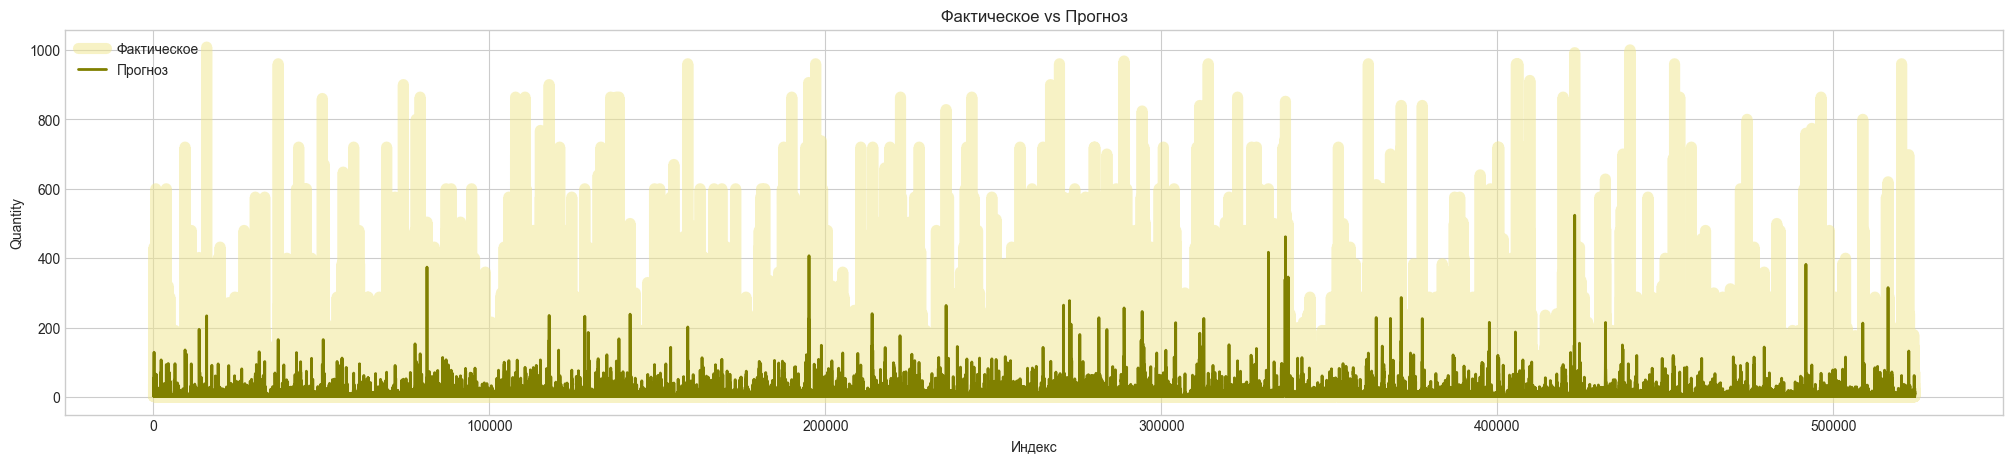

In [136]:
plt.figure(figsize=(25, 5))
plt.plot(y_true, label="Фактическое", color="khaki", alpha=0.5, linewidth=8)
plt.plot(y_pred, label="Прогноз", color='olive', linewidth=2)
plt.title("Фактическое vs Прогноз")
plt.xlabel("Индекс")
plt.ylabel("Quantity")
plt.legend()
plt.show()

**Анализ результатов модели LSTM**

- **MSE:** 603.73 — высокая средняя квадратическая ошибка, указывает на большие отклонения в прогнозах.
- **RMSE:** 24.57 — значительное среднеквадратичное отклонение, что говорит о слабой точности модели.
- **MAE:** 6.52 — средняя абсолютная ошибка достаточно велика.
- **R²:** 0.24 — низкое объяснение дисперсии, модель плохо улавливает зависимость.
- **MAPE:** 2.2e14 % — аномально высокое значение, возможно, из-за выбросов или нуля в целевой переменной.
- **MaxError:** 997.57 — крупные ошибки на отдельных наблюдениях.

**Вывод**:
Модель LSTM показывает недостаточную точность и стабильность на данных с текущей предобработкой и признаками. Высокие ошибки и низкое качество прогноза указывают на необходимость альтернативного подхода.

---

**Причины выбора LightGBM**

- **LightGBM проще и быстрее учится.** 

- **LightGBM хорошо умеет работать с разными типами данных и не требует сложного масштабирования.**

- **LightGBM — проверенный инструмент для задач регрессии на бизнес-данных.**


# 8. Модель LGBM, обучение, прогноз


In [142]:
from lightgbm import LGBMRegressor, early_stopping, log_evaluation
from sklearn.model_selection import train_test_split

In [143]:
# 1. Разделяем признаки и целевую переменную
X = df_clean[selected_features]  
y = df_clean[target]  

# 2. Разбиваем на train/val
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, shuffle=False  
)

# 3. Инициализируем модель
model = LGBMRegressor(
    n_estimators=500,
    learning_rate=0.05,
    random_state=42
)

# 4. Обучаем модель с ранней остановкой и логом каждые 50 итераций
model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    callbacks=[
        early_stopping(stopping_rounds=50),
        log_evaluation(period=50) 
    ]
)



[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014277 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 820
[LightGBM] [Info] Number of data points in the train set: 419378, number of used features: 14
[LightGBM] [Info] Start training from score 1.734382
Training until validation scores don't improve for 50 rounds
[50]	valid_0's l2: 0.0104305
[100]	valid_0's l2: 0.00132555
[150]	valid_0's l2: 0.00080536
[200]	valid_0's l2: 0.000629713
[250]	valid_0's l2: 0.000531386
[300]	valid_0's l2: 0.000472966
[350]	valid_0's l2: 0.000430999
[400]	valid_0's l2: 0.000397137
[450]	valid_0's l2: 0.000365289
[500]	valid_0's l2: 0.000343919
Did not meet early stopping. Best iteration is:
[500]	valid_0's l2: 0.000343919


,boosting_type,'gbdt'
,num_leaves,31
,max_depth,-1
,learning_rate,0.05
,n_estimators,500
,subsample_for_bin,200000
,objective,None
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


In [144]:
# 5. Предсказания и метрики
y_pred_log = model.predict(X_val)  
y_pred = np.expm1(y_pred_log).flatten()  
y_true_log = y_val.values.reshape(-1)
y_true = np.expm1(y_true_log).flatten()
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)
medae = median_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)
mape = mean_absolute_percentage_error(y_true, y_pred) * 100
maxerr = max_error(y_true, y_pred)

metrics_dict = {
        "MSE": mse,
        "RMSE": rmse,
        "MAE": mae,
        "MedAE": medae,
        "R2": r2,
        "MaxError": maxerr
    }
for k, v in metrics_dict.items():
    print(f"{k}: {v:.4f}")

MSE: 23.2181
RMSE: 4.8185
MAE: 0.2401
MedAE: 0.0128
R2: 0.9627
MaxError: 586.0942


In [145]:
results = pd.DataFrame({
    'y_true': y_true,   
    'y_pred': y_pred                   
}, index=y_val.index)


results['StockCode'] = df_clean.loc[results.index, 'StockCode']
results['InvoiceDate'] = df_clean.loc[results.index, 'InvoiceDate']
results["CustomerID"] = df_clean.loc[results.index, "CustomerID"]
results["Description"] = df_clean.loc[results.index, "Description"]


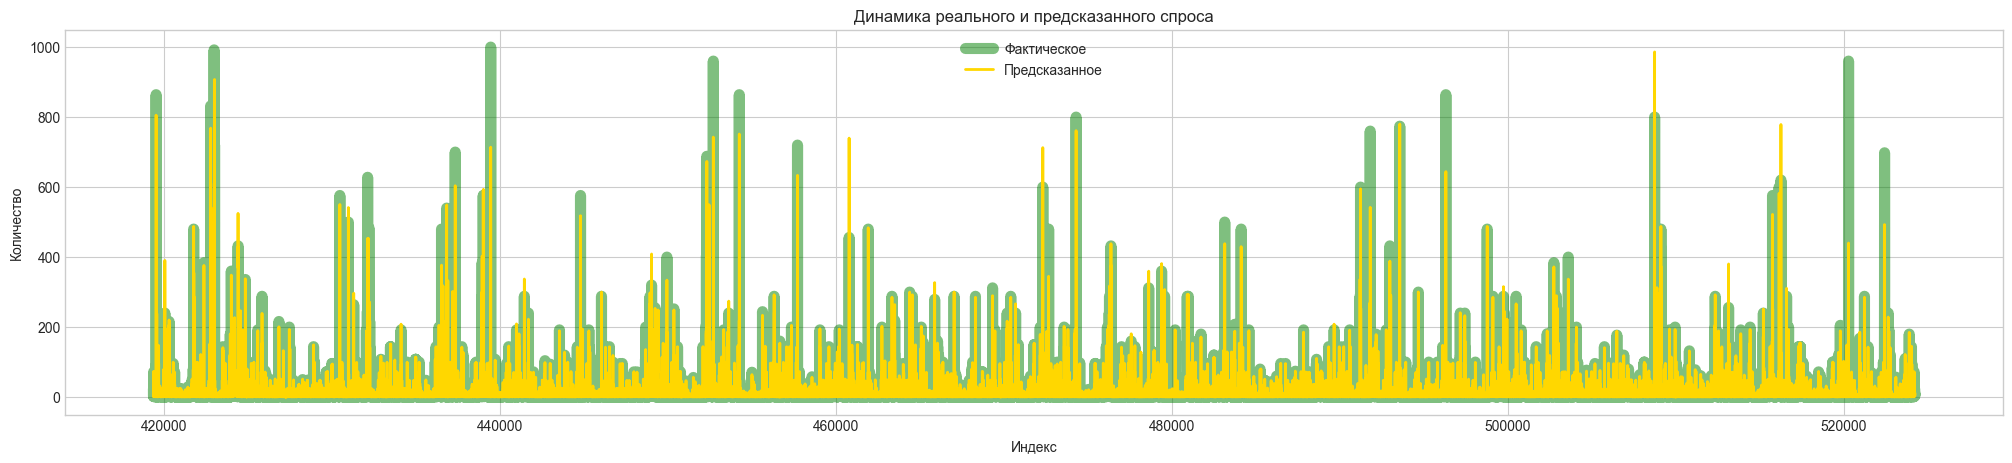

In [152]:
plt.figure(figsize=(25, 5))
plt.plot(results.index, results['y_true'], label="Фактическое", color="green", alpha=0.5, linewidth=8)
plt.plot(results.index, results['y_pred'], label='Предсказанное', color='gold', linewidth=2)
plt.xlabel('Индекс')
plt.ylabel('Количество')
plt.title('Динамика реального и предсказанного спроса') 
plt.legend()
plt.show()

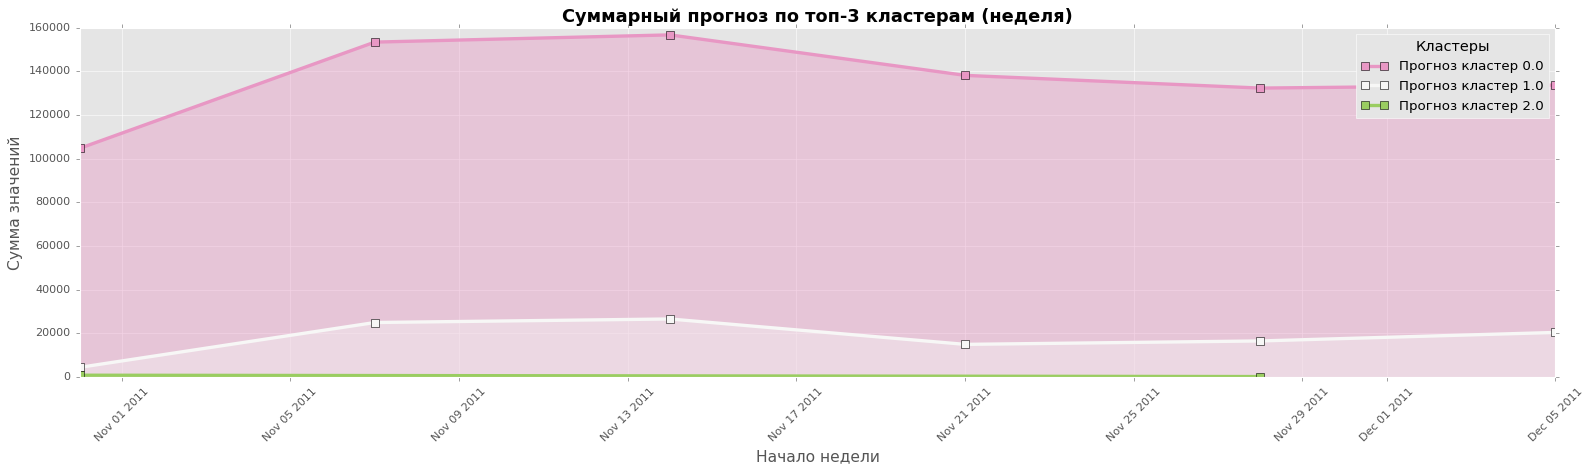

In [172]:
results['RFM_Cluster'] = df_clean.loc[results.index, 'RFM_Cluster']
results['WeekStart'] = results['InvoiceDate'].dt.to_period('W').apply(lambda r: r.start_time)

weekly_cluster = results.groupby(['WeekStart', 'RFM_Cluster']).agg(
    y_true_sum=('y_true', 'sum'),
    y_pred_sum=('y_pred', 'sum')
).reset_index()

top_clusters = (weekly_cluster
                .groupby('RFM_Cluster')['y_pred_sum']
                .sum()
                .sort_values(ascending=False)
                .head(3)
                .index.tolist())

weekly_cluster_top = weekly_cluster[weekly_cluster['RFM_Cluster'].isin(top_clusters)]

palette = sns.color_palette('PiYG', n_colors=len(top_clusters))

plt.figure(figsize=(20, 6))

for i, cluster in enumerate(top_clusters):
    cluster_data = weekly_cluster_top[weekly_cluster_top['RFM_Cluster'] == cluster]
    
    x = cluster_data['WeekStart']
    y = cluster_data['y_pred_sum']
    
    plt.plot(
        x,
        y,
        label=f"Прогноз кластер {cluster}",
        color=palette[i],
        marker='s',
        linestyle='-',
        linewidth=3,
        markersize=7,
        alpha=1
    )
    
    
    plt.fill_between(
        x,
        y,
        alpha=0.4,             
        color=palette[i]
    )

plt.title("Суммарный прогноз по топ-3 кластерам (неделя)", fontsize=16, fontweight='bold')
plt.xlabel("Начало недели", fontsize=14)
plt.ylabel("Сумма значений", fontsize=14)
plt.xticks(rotation=45)
plt.legend(title='Кластеры', fontsize=12, title_fontsize=13)
plt.grid(True)
plt.tight_layout()
plt.show()

- Модель демонстрирует **высокую точность** и надежность прогнозов по основным показателям.
- Значение R² близко к 1 говорит о том, что модель отлично подгоняет данные и может использоваться для бизнес-задач.
- Небольшие средние и медианные ошибки указывают на то, что большинство прогнозов очень точны.
- Максимальная ошибка свидетельствует о наличии редких сложных случаев, которые требуют дополнительного анализа.

---

**Рекомендации**

- Внедрить модель для оперативного прогнозирования спроса и управления запасами.
- Регулярно отслеживать качество прогнозов и обновлять модель на новых данных.
- Провести анализ выбросов для снижения максимальных ошибок в долгосрочной перспективе.